# Отчёт по лабораторной работе №3

## А-13а-19 Кутдусов Руслан  Номер по журналу 11

### Задача 3.1.

#### Постановка:

Реализовать решение СЛАУ с помощью LU разложения, которое $\textbf{реализовано в виде двух функций, одна из которых возвращает 
две матрицы – L и U, не модифицируя A, а вторая функция решает систему,}$ и с помощью LU разложения по схеме частичного выбора, которое $\textbf{модифицирует исходную матрицу А}$. Решить систему небольшой размерности с возмущенной матрицей обоими методами, оценить погрешность и сравнить с теоретической оценкой. Проанализировать поведение методов с ростом числа уравнений.

$ A_{i,j} = \sin^{20 - j}{(i+1)}$

In [1]:
import numpy as np
from scipy import linalg

In [2]:
#элемент матрицы A
def aij (i, j):
    return np.sin(i+1) ** (20 - j)

In [3]:
#заполнение матрицы
def matrix_creation (n):
    return np.array([[aij(i, j) for i in range(n)] for j in range(n)])

In [4]:
#создание матриц L и U
def LU (A): 
    n = A.shape[0]
    LU = np.matrix(np.zeros((n, n)))
    for t in range(n):
        for j in range(t, n):
            LU[t, j] = A[t, j] - LU[t, :t] * LU[:t, j]
        for i in range(t + 1, n):
            LU[i, t] = (A[i, t] - LU[i, :t] * LU[:t, t]) / LU[t, t]
     
    L = LU.copy()
    U = LU.copy()
    for i in range(n):
        L[i, i] = 1
        L[i, i + 1 :] = 0
    for j in range(1, n):
        U[j, :j] = 0
        
    return L, U

In [5]:
#решение системы
def solve_LU (L, U, b):
    n = L.shape[0]
    y = np.zeros((n, 1))
    for i in range(n):
        y[i] = b[i] - L[i, :i] * y[:i]
    
    x = np.zeros((n, 1))
    for i in range(1, n + 1):
        x[-i] = (y[-i] - U[-i, -i:] * x[-i:]) / U[-i, -i]        
    
    return x

In [6]:
#проверка 
A = np.matrix([[1, 2, 9] , [0, 5, 6], [1, 8, 5]])
b = np.array([10, 11, 12])
print("x = ", linalg.solve(A, b)) #встроенная scipy функция

x =  [-1.  1.  1.]


In [7]:
L, U = LU(A)
print(L @ U)
print("Mtx L ", L, '\n', "Mtx U ", U)
print("x = ", solve_LU(L, U, b).reshape(3)) # наша функция

[[1. 2. 9.]
 [0. 5. 6.]
 [1. 8. 5.]]
Mtx L  [[1.  0.  0. ]
 [0.  1.  0. ]
 [1.  1.2 1. ]] 
 Mtx U  [[  1.    2.    9. ]
 [  0.    5.    6. ]
 [  0.    0.  -11.2]]
x =  [-1.  1.  1.]


In [8]:
#поиск максимума в столбце на k-ом шаге - перестановка строк
def modif_mtx (A, P, col):
    max_el = A[col, col]
    ind = col
    for i in range(col + 1, A.shape[0]):
        if abs(A[i, col]) > abs(max_el):
            max_el = A[i, col]
            ind = i
    if ind != col:
        A[[col, ind]] = A[[ind, col]]
        P[[col, ind]] = P[[ind, col]]
    return

In [11]:
#матрица A в методе с частичным выбором модифицируется
def LU_m (A, b):
    n = A.shape[0]
    P = np.eye(n)
    U = np.float64(A)
    for k in range(n - 1):
        P_ = np.eye(n)       #матрица перестановок на K-ом шаге
        modif_mtx(U, P_, k)  #перестановка строк в матрице A и в P_
        for i in range(k + 1, n):
            div = U[i, k] / U[k, k]
            U[i, k] = div
            if div != 0:
                for j in range(k + 1, n):
                    U[i, j] -= div * U[k, j]
        P = P_ @ P #вычисление итоговой
    
    L = U.copy()
    for i in range(n):
        L[i, i] = 1
        L[i, i + 1 :] = 0
    for j in range(1, n):
        U[j, :j] = 0
    
    b = P @ b
    y = np.zeros(n)
    x = np.zeros(n)
        
    for i in range(n):
         y[i] = b[i] - np.sum([L[i, j] * y[j] for j in range(i)])
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - np.sum([x[j] * U[i, j] for j in range(n-1, i-1, -1)])) / U[i, i]
        
    return P, L, U, x

In [12]:
#матрицу и вектор b
A_def = matrix_creation(5)
#Х точное
x_def = np.array([21] * 5)
#b точное
b_def = A_def @ x_def
#b возмущённое
b = b_def.copy()
#A возмущенное
A = np.copy(A_def)
A[0][0] += 10e-03
print(A)

[[ 4.16798348e-02  1.49320433e-01  9.81232336e-18  3.79884091e-03
   4.32201484e-01]
 [ 3.76481607e-02  1.64215172e-01  6.95317659e-17 -5.01959354e-03
  -4.50714927e-01]
 [ 4.47408899e-02  1.80595664e-01  4.92713732e-16  6.63263344e-03
   4.70021397e-01]
 [ 5.31698546e-02  1.98610112e-01  3.49145199e-15 -8.76402163e-03
  -4.90154863e-01]
 [ 6.31867950e-02  2.18421504e-01  2.47410132e-14  1.15803287e-02
   5.11150751e-01]]


In [14]:
L1, U1 = LU(A)
x1 = solve_LU(L1, U1, b).reshape(5)
L2, U2, P2, x2 = LU_m(A, b)
print(x1)
print(x2)
print(linalg.solve(A, b))

[-9.52795999e+03  2.43492387e+03  5.88131062e+15 -1.81334360e+04
  2.88838660e+02]
[-9.52795999e+03  2.43492387e+03  5.88131062e+15 -1.81334360e+04
  2.88838660e+02]
[-9.52795999e+03  2.43492387e+03  5.88131062e+15 -1.81334360e+04
  2.88838660e+02]


In [15]:
def delta_x(x, x_def):
    return linalg.norm(x - x_def, ord = 2) / linalg.norm(x, ord = 2)

In [16]:
b[0] += 10e-03
th = np.linalg.cond(A) * delta_x(b, b_def)
print(np.linalg.cond(A))
print(th)
print(delta_x(x2, x_def))

507616905909556.0
188377145146.87766
0.9999999999999964


In [17]:
#массивы с погрешностями
delta_x1 = []
delta_x2 = []

for i in range(5, 17):
    A_def = matrix_creation(i)
    x_def = np.array([21] * i)
    b = A_def @ x_def
    A = np.copy(A_def)
    A[0][0] += 1e-3 
    L1, U1 = LU(A)
    x1 = solve_LU(L1, U1, b).reshape(i)
    L2, U2, P2, x2 = LU_m(A, b)
    delta_x1.append(delta_x(x1,x_def))
    delta_x2.append(delta_x(x2,x_def))

In [18]:
from matplotlib import pyplot as plt

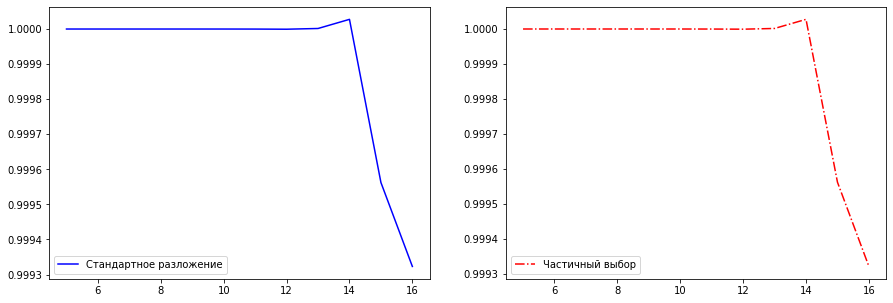

In [19]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
axs[0].plot(range(5,17), delta_x1, color = 'blue', ls = 'solid',label = 'Стандартное разложение')
axs[1].plot(range(5,17), delta_x2, color = 'red', ls = 'dashdot',label = 'Частичный выбор')
axs[0].legend()
axs[1].legend()

In [20]:
def solve_mysys (t1, t2, b):
    x = np.zeros(70)
    x[64] = b[5] / t1
    for i in range(70):
        if i != 64:
            x[i] = (b[-i - 1] - t2 * x[64]) / t1
    return x

In [21]:
t_side_diag = 50
t_65 = 10
b = [60] * 70
b[5] = 50
solve_mysys(t_side_diag, t_65, b)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [23]:
b = np.array([i**2 - 100 for i in range(70)])
print(np.around(solve_mysys(t_side_diag, t_65, b), 3))

[ 9.352e+01  9.078e+01  8.808e+01  8.542e+01  8.280e+01  8.022e+01
  7.768e+01  7.518e+01  7.272e+01  7.030e+01  6.792e+01  6.558e+01
  6.328e+01  6.102e+01  5.880e+01  5.662e+01  5.448e+01  5.238e+01
  5.032e+01  4.830e+01  4.632e+01  4.438e+01  4.248e+01  4.062e+01
  3.880e+01  3.702e+01  3.528e+01  3.358e+01  3.192e+01  3.030e+01
  2.872e+01  2.718e+01  2.568e+01  2.422e+01  2.280e+01  2.142e+01
  2.008e+01  1.878e+01  1.752e+01  1.630e+01  1.512e+01  1.398e+01
  1.288e+01  1.182e+01  1.080e+01  9.820e+00  8.880e+00  7.980e+00
  7.120e+00  6.300e+00  5.520e+00  4.780e+00  4.080e+00  3.420e+00
  2.800e+00  2.220e+00  1.680e+00  1.180e+00  7.200e-01  3.000e-01
 -8.000e-02 -4.200e-01 -7.200e-01 -9.800e-01 -1.500e+00 -1.380e+00
 -1.520e+00 -1.620e+00 -1.680e+00 -1.700e+00]


In [24]:
def seidel(A, b, eps):
    n = A.shape[0]
    #найдём матрицу B, B1, B2
    B = np.matrix(np.array([[-A[i, j] / A[i, i] if i != j else 0 for j in range(n)] for i in range(n)]))
    B1 = np.matrix(np.array([[B[i, j] if i > j else 0 for j in range(n)] for i in range(n)]))
    B2 = np.matrix(np.array([[B[i, j] if i < j else 0 for j in range(n)] for i in range(n)]))
    eps1 = ((1 - linalg.norm(B, ord = np.inf)) * eps) / linalg.norm(B2, ord = np.inf)
    if linalg.norm(B1, ord = np.inf) + linalg.norm(B2, ord = np.inf) < 1:
        x_ = np.array([0] * n)
        x = np.array([0] * n)
        it = 1
        while True:
            for i in range(n):
                x[i] = (b[i] / A[i, i]) + sum(B1[i, j] * x[j] for j in range(i)) + sum(B2[i, j] * x_[j] for j in range(i, n))
            if linalg.norm(x - x_, ord = 2) < eps1:
                break
            else:
                x_ = x
                it += 1
        print("Mtx B = \n", B)
        print("eps1 = ", eps1)
        print("Norm Mtx B = \n", linalg.norm(B, ord = np.inf))
        return x, it

In [27]:
A = np.array([
             [np.math.cos(i + j)/(90) + 90 * np.math.exp(-(i - j)**2) for j in range(10)] 
             for i in range(10)]
             )
x_def = np.array([21] * 10)
b = A @ x_def
print("Mtx A = \n", A)
x, it = seidel(A, b, 10 ** (-10))
print("x = ",x_def)
print("x* = ", x)
print("iterations number = ", it)

Mtx A = 
 [[ 9.00111111e+01  3.31151531e+01  1.64378365e+00  1.06965739e-04
  -7.25257873e-03  3.15180331e-03  1.06685587e-02  8.37669171e-03
  -1.61666704e-03 -1.01236696e-02]
 [ 3.31151531e+01  8.99953761e+01  3.30981498e+01  1.64114479e+00
   1.42586844e-02  1.06786869e-02  8.37669296e-03 -1.61666704e-03
  -1.01236696e-02 -9.32301699e-03]
 [ 1.64378365e+00  3.30981498e+01  8.99927373e+01  3.31123015e+01
   1.65907606e+00  1.94835741e-02 -1.60653888e-03 -1.01236683e-02
  -9.32301699e-03  4.91744221e-05]
 [ 1.06965739e-04  1.64114479e+00  3.31123015e+01  9.00106686e+01
   3.31175264e+01  1.64679083e+00  9.83212791e-04 -9.31288882e-03
   4.91756720e-05  9.37615510e-03]
 [-7.25257873e-03  1.42586844e-02  1.65907606e+00  3.31175264e+01
   8.99983833e+01  3.30990260e+01  1.63908448e+00  1.11560568e-02
   9.38628326e-03  1.00827433e-02]
 [ 3.15180331e-03  1.06786869e-02  1.94835741e-02  1.64679083e+00
   3.30990260e+01  8.99906770e+01  3.31091989e+01  1.65778366e+00
   2.11896244e-02  1.52